# Adam Cabral
## CSC 310 Final Project Proposal

### Individual App Project: Automated Car Appraiser


My app I have made is a Car Appraiser. It is a basic GUI based app using Tkinter that has multiple fields for the user to fill in regarding their cars information. The information given is then fed through the KNN Model that is trained here in this Jupyter Notebook.

<img src="gui-screenshot.jpg" width=500>




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [344]:
df = pd.read_csv("autos.csv")

## Clean up data

1. Drop useless columns
2. Convert German words/units to English/Imperial units
3. Deal with NaN's

In [345]:
# Drop useless columns 
df.drop(["name", "abtest", "seller", "dateCrawled", "offerType", "dateCreated", "nrOfPictures", "postalCode", "lastSeen"], axis=1, inplace=True)

#### Fill NaN's with data

In [346]:
df.rename(columns={"kilometer":"miles", "powerPS":"HPower"}, inplace=True)

df.vehicleType.fillna("Other", inplace=True)
df.gearbox.fillna("manual", inplace=True)
df.model.fillna("Other", inplace=True)
df.notRepairedDamage.fillna("no", inplace=True)
df.fuelType.fillna("Gasoline", inplace=True)
df.price.fillna(df.price.mean(), inplace=True)
df.miles.fillna(df.price.mean(), inplace=True)

#### Translate German words to English

In [347]:
#Map German words to english
df['gearbox'] = df['gearbox'].map({'manuell':'manual', 'automatik':'automatic', 'manuel':'manuel'}).astype(str)
df['miles'] = df['miles'].map(lambda x: int(x*0.62137))
# df.rename(columns={"kilometer":"miles", "powerPS":"HPower"}, inplace=True)

# lpg: Liquefied petroleum gas
# benzin: Regular Gasoline
# cng: Compressed Natural Gas
# andere: Other
# elektro: Electric
df['fuelType'] = df['fuelType'].map({"benzin":"Gasoline", "andere":"other", "elektro":"electric", "lpg":"lpg", "cng":"cng", "diesel":"diesel", "hybrid":"hybrid", "Other":"Other", "Gasoline":"Gasoline"})

df['notRepairedDamage'] = df['notRepairedDamage'].map({"nein":"no", "ja":"yes"})
df['vehicleType'] = df['vehicleType'].map({'limousine': 'sedan', 'kleinwagen':'mini','kombi':'combination', "bus":"bus",'cabrio':'convertable',"coupe":"coupe", "suv":"suv", 'andere': 'Other', 'Other':"Other"})


#### Enumerate Values for Regression

In [348]:
# Vehicle Type Enumeration
vehicleTypes = {}
count = 0
for entry in df['vehicleType']:
    if entry not in vehicleTypes:
        vehicleTypes[entry] = count
        count+=1
# df["vehicleType"] = df['vehicleType'].map(vehicleTypes)

# Gearbox Enumeration
count = 0
gearBoxes = {}
for entry in df['gearbox']:
    if entry not in gearBoxes:
        gearBoxes[entry] = count
        count+=1
# df["gearbox"] = df['gearbox'].map(gearBoxes)

# Model Enumeration
count = 0
models = {}
for entry in df['model']:
    if entry not in models:
        models[entry] = count
        count+=1
# df["model"] = df["model"].map(models)

# Fuel type Enumeration
count = 0
fuelTypes = {}
for entry in df['fuelType']:
    if entry not in fuelTypes:
        fuelTypes[entry] = count
        count+=1
# df["fuelType"] = df["fuelType"].map(fuelTypes)

# Brand Enumeration
count = 0
brands = {}

for entry in df['brand']:
    if entry not in brands:
        brands[entry] = count
        count+=1

# df['brand'] = df['brand'].map(brands)

count = 0
damages = {}
for entry in df["notRepairedDamage"]:
    if entry not in damages:
        damages[entry] = count
        count+=1
del damages[np.nan]
# df["notRepairedDamage"] = df["notRepairedDamage"].map(damages)



# Make Dummy Variables for Classification Columns
cols = ['vehicleType','gearbox','model','fuelType','brand', "notRepairedDamage"]

df = pd.get_dummies(df, columns=cols)

# Remove outliers
df = df[(df.price <= 40000) & (df.price >= 300)]

### Setup Training and Testing Sets

In [349]:

# min_max = preprocessing.MinMaxScaler()
# feat_min_max = min_max.fit_transform( df.drop(["price"], axis=1))

target_df = df["price"]
feat_df = df.drop(["price"], axis=1)


In [350]:


train_feat, test_feat, train_targ, test_targ = train_test_split(feat_df, target_df, train_size=0.7, test_size=0.3, shuffle=True)

# train_feat, test_feat, train_targ, test_targ = train_test_split(feat_min_max, target_df, train_size=0.7, test_size=0.3)




# Linear Regression Model

In [269]:
pipeline = make_pipeline(LinearRegression())

linear_model = pipeline.fit(train_feat, train_targ)
# linear_model = LinearRegression(fit_intercept=True)
# linear_model.fit(train_feat, train_targ)

In [270]:
linear_scores = cross_val_score(linear_model, test_feat, test_targ, cv=3)
print("Fold Accuracies: {}".format(linear_scores))
print("Mean Linear Regression Accuracy: {}".format(linear_scores.mean()))

Fold Accuracies: [-3.54761333e+04  5.67843059e-01 -3.06782440e+06]
Mean Linear Regression Accuracy: -1034433.3230997379


In [271]:
test = df.iloc[3,:]
print(test.price)
test.drop(["price"], inplace=True)
print(linear_model.predict([test]))


1500
[2243.94968691]


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


# MLP Model

In [233]:
# seed = np.random.seed()


pipeline = make_pipeline(MLPRegressor())
# mlp_model = MLPRegressor(activation="logistic", hidden_layer_sizes=(25,50,100), max_iter=100, verbose=True, learning_rate = 'adaptive', learning_rate_init = 100)
mlp_model = pipeline.fit(train_feat, train_targ)

Iteration 1, loss = 17238606.93852156
Iteration 2, loss = 13343044.52682219
Iteration 3, loss = 11243414.63982823
Iteration 4, loss = 10323882.22066487
Iteration 5, loss = 9907053.29248509
Iteration 6, loss = 9611432.61440523
Iteration 7, loss = 9440958.07875784
Iteration 8, loss = 9265122.18711707
Iteration 9, loss = 9121857.71370903
Iteration 10, loss = 8935755.72172730
Iteration 11, loss = 8807202.38586879
Iteration 12, loss = 8688701.53802719
Iteration 13, loss = 8559949.62333084
Iteration 14, loss = 8423574.76094823
Iteration 15, loss = 8335973.40978088
Iteration 16, loss = 8208557.04810291
Iteration 17, loss = 8144357.17400348
Iteration 18, loss = 8064344.39261534
Iteration 19, loss = 7968025.66175765
Iteration 20, loss = 7925907.67784066
Iteration 21, loss = 7852595.91347859
Iteration 22, loss = 7834237.84503838
Iteration 23, loss = 7754087.25349305
Iteration 24, loss = 7734185.25190200
Iteration 25, loss = 7699283.99044841
Iteration 26, loss = 7663477.90055393
Iteration 27, los

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [234]:
print("MLP R^2 score: {}".format(mlp_model.score(test_feat, test_targ)))

MLP R^2 score: 0.7187905051709462


## KNN Regression

In [357]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights = "distance")

In [358]:
knn_model.fit(train_feat, train_targ)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')

In [359]:
print("KNN R^2 score : {}".format(knn_model.score(test_feat,test_targ)))

KNN R^2 score : 0.8294540905499531


# Export model and dictionaries using pickle

In [337]:
# Make a default test row
test_df = feat_df.iloc[2,:].copy()

for i in range(len(test_df)):
    test_df[i] = 0

test_df

yearOfRegistration       0
HPower                   0
miles                    0
monthOfRegistration      0
vehicleType_Other        0
                        ..
brand_trabant            0
brand_volkswagen         0
brand_volvo              0
notRepairedDamage_no     0
notRepairedDamage_yes    0
Name: 2, Length: 316, dtype: int64

In [338]:
# index 0 = MLP Model 
# index 1 = Vehicle Types
# index 2 = Gearbox Types
# index 3 = Model Types
# index 4 = Fuel Types
# index 5 = Make Types
# index 6 = Damage Types
structures = [knn_model, vehicleTypes, gearBoxes, models, fuelTypes, brands, damages]

In [341]:
output_filename = 'data_structures-knn3.sav'
output_filename

'data_structures-knn3.sav'

In [342]:
pickle.dump(structures, open(output_filename, 'wb'))
pickle.dump(test_df, open("default_df.sav", 'wb'))

### Test that the pickle export worked

In [334]:

test = pickle.load(open(output_filename, 'rb'))
aaa = pickle.load(open("default_df.sav", 'rb'))

In [335]:

test[0].predict([aaa])

array([4630.])

In [336]:
test_df = df.iloc[5,:].copy()
test_df

price                      650
yearOfRegistration        1995
HPower                     102
miles                    93205
monthOfRegistration         10
                         ...  
brand_trabant                0
brand_volkswagen             0
brand_volvo                  0
notRepairedDamage_no         0
notRepairedDamage_yes        1
Name: 5, Length: 317, dtype: int64

In [311]:
test_df.drop(["price"], inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3917: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


In [312]:
mlp_model.predict([test_df])

array([1163.48576702])

In [330]:
knn_model.predict([aaa])

array([4630.])


0.8330597693284005

0.24772994330080197


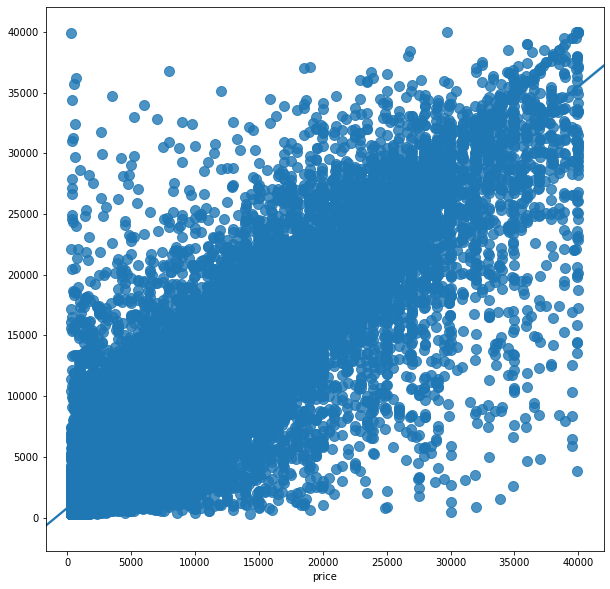

In [300]:
expected_y  = test_targ
predicted_y = knn_model.predict(test_feat)

print(); print(metrics.r2_score(expected_y, predicted_y))
print(); print(metrics.mean_squared_log_error(expected_y, predicted_y))
plt.figure(figsize=(10,10))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})


In [97]:
df.head(1000)

,price,vehicleType,yearOfRegistration,gearbox,HPower,model,miles,monthOfRegistration,fuelType,brand,notRepairedDamage
0,480,0,1993,0,0,0,93205,0,0,0,0
1,18300,1,2011,0,190,1,77671,5,1,1,1
2,9800,2,2004,1,163,2,77671,8,1,2,0
3,1500,3,2001,0,75,0,93205,6,0,0,0
4,3600,3,2008,0,69,3,55923,7,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...
995,1999,5,1996,0,131,6,77671,4,0,15,0
996,139997,1,2010,0,435,152,12427,3,0,27,0
997,3999,5,2007,1,84,29,93205,9,0,17,0
998,2600,0,2017,1,101,9,93205,4,1,0,0
